In [1]:
# !pip install -q transformers
# !pip install -q sentencepiece
# !pip install -q jiwer
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q -U accelerate
 
 
# !pip install -q matplotlib
# !pip install -q protobuf==3.20.1
# !pip install -q tensorboard

In [2]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

/home/fioritjx/Image Rec/Image-Recognition-Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
seed_everything(42)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import xml.etree.ElementTree as ET

In [5]:
def get_label(inkml_file_abs_path):
    tree = ET.parse(inkml_file_abs_path)
    root = tree.getroot()
    doc_namespace = "{http://www.w3.org/2003/InkML}"

    for child in root:
        if (child.tag == doc_namespace + 'annotation') and (child.attrib == {'type': 'truth'}):
            return child.text #.strip(' $\t\n\r\x0b\x0c')

In [6]:
def get_traces_data(inkml_file_abs_path):

        traces_data = []

        tree = ET.parse(inkml_file_abs_path)
        root = tree.getroot()
        doc_namespace = "{http://www.w3.org/2003/InkML}"

        'Stores traces_all with their corresponding id'
        traces_all = [{'id': trace_tag.get('id'),
                        'coords': [[round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
                                        for axis_coord in coord[1:].split(' ')] if coord.startswith(' ') \
                                    else [round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
                                        for axis_coord in coord.split(' ')] \
                                for coord in (trace_tag.text).replace('\n', '').split(',')]} \
                                for trace_tag in root.findall(doc_namespace + 'trace')]

        'Sort traces_all list by id to make searching for references faster'
        traces_all.sort(key=lambda trace_dict: int(trace_dict['id']))

        'Always 1st traceGroup is a redundant wrapper'
        traceGroupWrapper = root.find(doc_namespace + 'traceGroup')

        if traceGroupWrapper is not None:
            for traceGroup in traceGroupWrapper.findall(doc_namespace + 'traceGroup'):

                label = traceGroup.find(doc_namespace + 'annotation').text
                id = traceGroup.get('{http://www.w3.org/XML/1998/namespace}id')     

                'traces of the current traceGroup'
                traces_curr = []
                for traceView in traceGroup.findall(doc_namespace + 'traceView'):

                    'Id reference to specific trace tag corresponding to currently considered label'
                    traceDataRef = int(traceView.get('traceDataRef'))

                    'Each trace is represented by a list of coordinates to connect'
                    single_trace = traces_all[traceDataRef]['coords']
                    traces_curr.append(single_trace)


                traces_data.append({'label': label, 'trace_group': traces_curr, 'id':id})

        else:
            'Consider Validation data that has no labels'
            [traces_data.append({'trace_group': [trace['coords']]}) for trace in traces_all]

        return traces_data

In [7]:
# get_label('./offline-crohme/CROHME_labeled_2016/CROHME_testGT/algb02.inkml')

In [8]:
def get_image(file):
    traces = get_traces_data(file)
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.set_axis_off()
    for elem in traces:
        ls = elem['trace_group']
        for subls in ls:
            data = np.array(subls)
            x,y=zip(*data)
            ax.plot(x,y,linewidth=2,c='black')
    fig.set_frameon(False)
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    w = image.width
    h = image.height
    if w<h:
        result = Image.new(image.mode, (h, h), (255,255,255))
        result.paste(image, (int((h-w)/2), 0))
        image = result
    elif h<w:
        result = Image.new(image.mode, (w, w), (255,255,255))
        result.paste(image, (0, int((w-h)/2)))
        image = result
    plt.close()
    return image

In [9]:
# get_image('./offline-crohme/CROHME_labeled_2016/CROHME_testGT/algb02.inkml')

In [10]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

class CROHME_OCR_Dataset(Dataset):
    def __init__(self, files, processor, max_target_length=256) -> None:
        super().__init__()
        self.files = files
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        try:
            file = self.files[index]
            text = get_label(file)
            if text is None:
                return self[np.random.randint(len(self))]
            image = get_image(file)
            image = train_transforms(image)
            if image is None:
                return self[np.random.randint(len(self))]
            pixel_values = self.processor(image, return_tensors='pt').pixel_values
            labels = self.processor.tokenizer(
                text,
                padding='max_length',
                max_length=self.max_target_length
            ).input_ids
            labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
            if pixel_values is None or labels is None:
                return self[np.random.randint(len(self))]
            encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
            return encoding
        except:
            self[np.random.randint(len(self))]
        
        

In [11]:
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(glob.glob('./offline-crohme/CROHME_labeled_2016/*/*.inkml'),test_size=.1)
print(len(train_files),len(test_files))

11160 1241


In [12]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 8
    EPOCHS:        int = 16
    LEARNING_RATE: float = 0.0005
 
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-base-handwritten'

In [13]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CROHME_OCR_Dataset(train_files,processor)
valid_dataset = CROHME_OCR_Dataset(test_files,processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [14]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [15]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
 
 
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [16]:
# optimizer = optim.AdamW(
#     model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
# )

In [17]:
cer_metric = evaluate.load('cer')
 
 
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
 
 
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
 
 
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
 
 
    return {"cer": cer}

In [18]:
# training_args = Seq2SeqTrainingArguments(
#     predict_with_generate=True,
#     evaluation_strategy='epoch',
#     # per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
#     # per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
#     auto_find_batch_size = True,
#     fp16=True,
#     output_dir='seq2seq_model_printed/',
#     logging_strategy='epoch',
#     save_strategy='epoch',
#     save_total_limit=5,
#     report_to='tensorboard',
#     num_train_epochs=TrainingConfig.EPOCHS
# )

In [19]:
# # Initialize trainer.
# trainer = Seq2SeqTrainer(
#     model=model,
#     tokenizer=processor.feature_extractor,
#     args=training_args,
#     compute_metrics=compute_cer,
#     train_dataset=train_dataset,
#     eval_dataset=valid_dataset,
#     data_collator=default_data_collator,
# )

In [20]:
# res = trainer.train()

In [21]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(1400)).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [22]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

/tmp/ipykernel_748722/1093034455.py:15: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


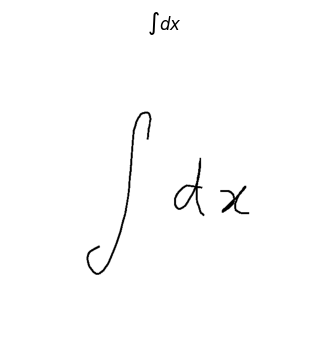

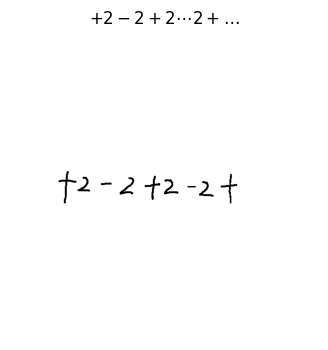

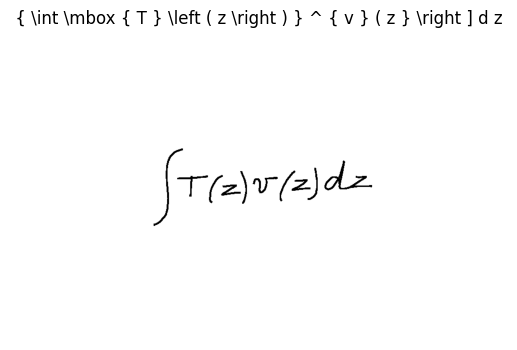

ValueError: 
x_0^2 + x_1^2+ x_2^{12}+x_3^{24}+\frac{x_4^{24}} = 0
                                      ^
ParseSyntaxException: Expected \frac{num}{den}, found '{'  (at char 38), (line:1, col:39)

<Figure size 700x400 with 1 Axes>

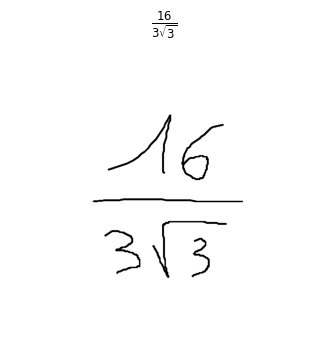

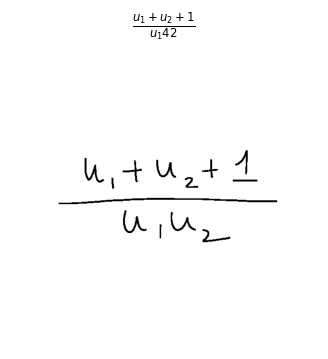

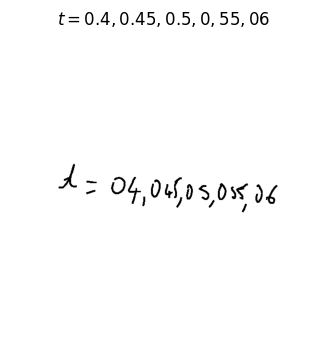

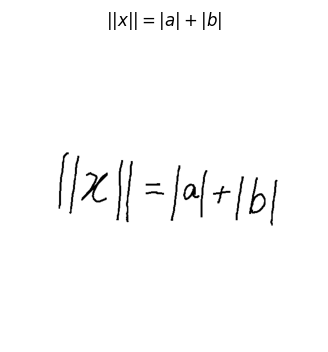

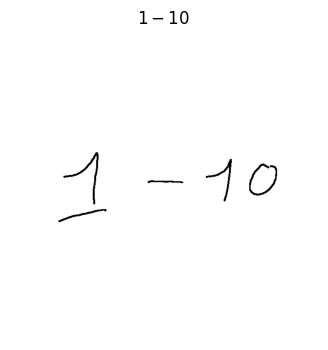

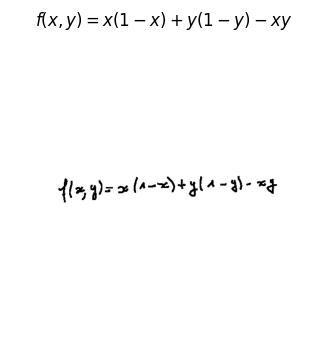

In [24]:
def eval_new_data(
    data_path='./offline-crohme/CROHME_labeled_2016/*/*.inkml',
    samples = range(50)
):
    image_paths = glob.glob(data_path)
    for i in samples:
        image = get_image(image_paths[i])
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()
        #     plt.figure(figsize=(7, 4))
        #     plt.imshow(image)
        #     plt.title("Ignore this the latex formatting was wrong")
        #     print(text)
        #     # plt.title(text)
        #     plt.axis('off')
        #     plt.show()
 
eval_new_data(
    data_path='./offline-crohme/CROHME_labeled_2016/*/*.inkml',
    samples= range(10)
    # [##Poll the audience for 5 numbers
             
    #          ]
)